In [1]:
import pandas as pd
import numpy as np
import sys, os
import re
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import emoji
import pydot
import errno
from matplotlib import rcParams
%matplotlib inline 

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from utility import FeatureGenerator
from rdkit.Chem import PandasTools as PandasTools
from rdkit import DataStructs
from rdkit.Chem.Subshape import SubshapeBuilder,SubshapeAligner,SubshapeObjects

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn.svm import SVR
from pprint import pprint
pd.set_option('display.max_rows', None)

In [2]:
rcParams['figure.figsize'] = 5,5
rcParams['axes.linewidth'] = 2.0
rcParams['savefig.dpi'] = 500
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [3]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [4]:
data1=pd.read_csv("data1.csv", header=0, sep=',', engine='python')
data2=pd.read_csv("data2.csv", header=0, sep=',', engine='python')
tmp1rcsb=pd.read_csv("allrcsb.csv", header=0, sep=',', engine='python')
tmp2rcsb=pd.read_csv("PDE2-data.csv", header=0, sep=',', engine='python')
nonbinders=pd.read_csv("nonbind.csv", header=0, sep=',', engine='python')

rcsb=pd.merge(tmp1rcsb, tmp2rcsb, how='left', on='title')
tmp=pd.concat([data1, data2], axis=0, ignore_index=True)

In [5]:
col1_to_drop = ['ID-Number','Domain','Plate Position','Plate Amount [µg]','Total Molweight',
                'Run Number','Plate Number','MolWeight','H-Acceptors','H-Donors','Rotatable Bonds',
                'Log P','Log S','Chemical Name','MolWeight.1','QC Method','Purity','Purity [%]',
                'MoFormula','Molweight',]
tmp.drop(col1_to_drop, axis=1, inplace=True)


col2_to_drop = ['Rank','Dock Score','Exp']
rcsb.drop(col2_to_drop, axis=1, inplace=True)
combined=pd.concat([tmp, rcsb], axis=0, ignore_index=True)
combined=pd.concat([combined, nonbinders], axis=0, ignore_index=True)

In [6]:
combined['binder'] = np.where(combined['IC50'].isnull(), 0, 1)

In [7]:
#missing values in columns
combined.isnull().sum(axis=0)

title       0
IC50      210
SMILES      0
binder      0
dtype: int64

In [8]:
rcsb.isnull().sum(axis=0)

SMILES    0
title     0
IC50      0
dtype: int64

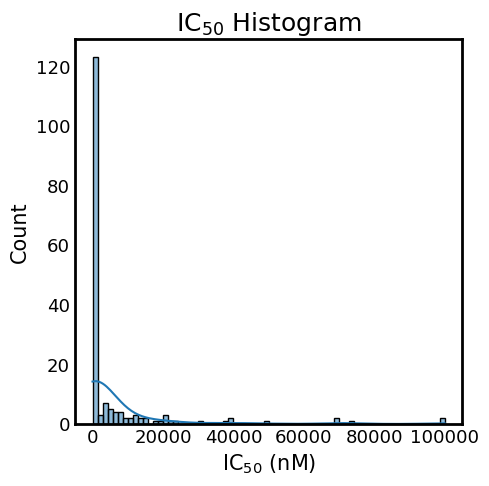

In [9]:
sns.histplot(combined['IC50'], kde=True, linewidth=1)
plt.title('IC$_{50}$ Histogram', fontsize=18)
plt.xlabel("IC$_{50}$ (nM)", fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tick_params(which='both',direction='in',length=0, width=3,)

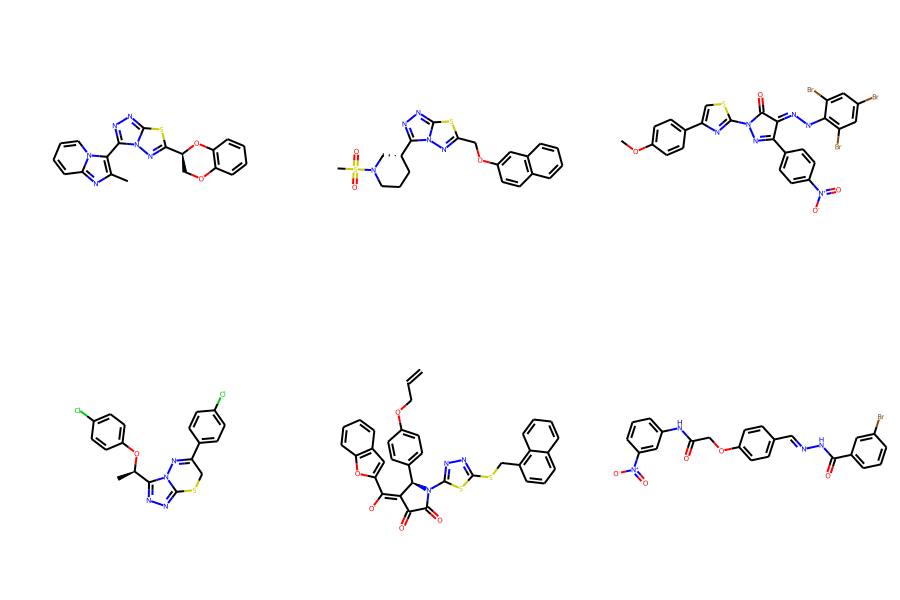

In [10]:
#Convert SMILES to 2D molecules:
molecules = combined.SMILES.apply(Chem.MolFromSmiles)
Draw.MolsToGridImage(molecules[:6],molsPerRow=3, subImgSize=(300, 300))

Tanimoto Similarity Coefficient of molecule_1 vs molecule_1: 1.0
Tanimoto Similarity Coefficient of molecule_1 vs molecule_2: 0.20430107526881722


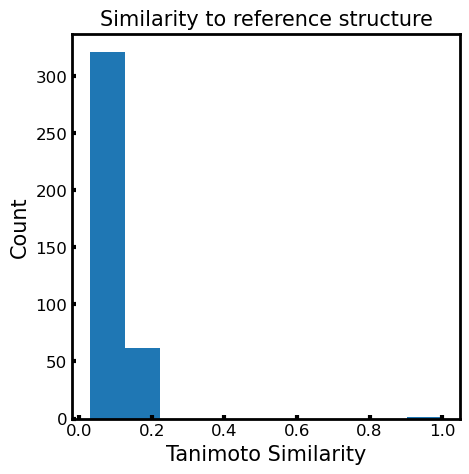

In [11]:
## Similarity Calculations

# We calculate Morgan fingerprints 
mols_fps=[AllChem.GetMorganFingerprintAsBitVect(x,2) for x in molecules]
print(f'Tanimoto Similarity Coefficient of molecule_1 vs molecule_1: {DataStructs.TanimotoSimilarity(mols_fps[0],mols_fps[0])}')
print(f'Tanimoto Similarity Coefficient of molecule_1 vs molecule_2: {DataStructs.TanimotoSimilarity(mols_fps[0],mols_fps[1])}')

# Calculate similarities to reference molecule
sim_ref = DataStructs.BulkTanimotoSimilarity(mols_fps[0],mols_fps)


# Calculate pairwise similarities
def pairwise_sim(mols):
    pairwise=[]
    for i in mols:
        sim = DataStructs.BulkTanimotoSimilarity(i,mols)
        pairwise.append(sim)
    return pairwise

PW = pairwise_sim(mols_fps)
plt.hist(sim_ref)
plt.title('Similarity to reference structure', fontsize=15)
plt.xlabel('Tanimoto Similarity', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(which='both',direction='in',length=3, width=3,)

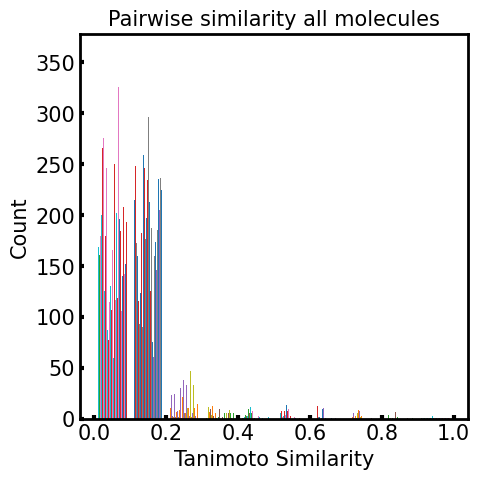

In [12]:
plt.hist(PW)
plt.title('Pairwise similarity all molecules', fontsize=15)
plt.xlabel('Tanimoto Similarity', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(which='both',direction='in',length=3, width=3,)

In [13]:
combined.loc[:, 'MolLogP'] = molecules.apply(Descriptors.MolLogP)
combined.loc[:, 'HeavyAtomCount'] = molecules.apply(Descriptors.HeavyAtomCount)
combined.loc[:, 'HAccept'] = molecules.apply(Descriptors.NumHAcceptors)
combined.loc[:, 'Heteroatoms'] = molecules.apply(Descriptors.NumHeteroatoms)
combined.loc[:, 'HDonor'] = molecules.apply(Descriptors.NumHDonors)
combined.loc[:, 'MolWt'] = molecules.apply(Descriptors.MolWt)
combined.loc[:, 'RotableBonds'] = molecules.apply(Descriptors.NumRotatableBonds)
combined.loc[:, 'RingCount'] = molecules.apply(Descriptors.RingCount)
combined.loc[:, 'Ipc'] = molecules.apply(Descriptors.Ipc)
combined.loc[:, 'HallKierAlpha'] = molecules.apply(Descriptors.HallKierAlpha)
combined.loc[:, 'NumValenceElectrons'] = molecules.apply(Descriptors.NumValenceElectrons)
combined.loc[:, 'SaturatedRings'] = molecules.apply(Descriptors.NumSaturatedRings)
combined.loc[:, 'AliphaticRings'] = molecules.apply(Descriptors.NumAliphaticRings)
combined.loc[:, 'AromaticRings'] = molecules.apply(Descriptors.NumAromaticRings)

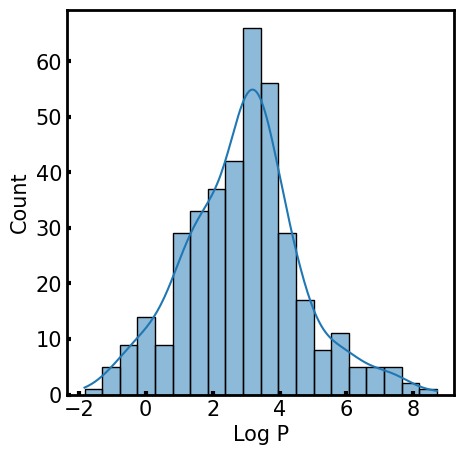

In [14]:
sns.histplot(combined['MolLogP'], kde=True, linewidth=1)
plt.xlabel('Log P', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(which='both',direction='in',length=3, width=3,)

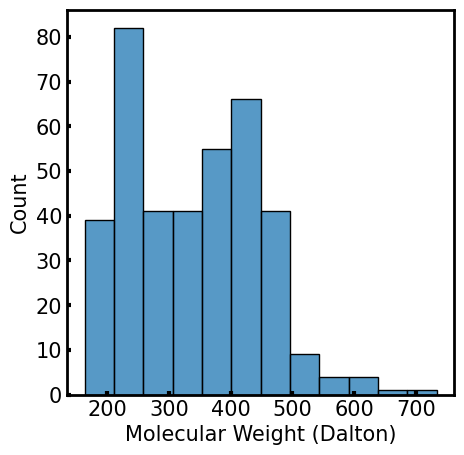

In [15]:
sns.histplot(combined['MolWt'], linewidth=1)
plt.xlabel('Molecular Weight (Dalton)', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(which='both',direction='in',length=3, width=3,)

In [16]:
X = combined.iloc[:, 4:]
y = np.array(combined['binder'])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train, y_train)
#Evaluate the model:
print("accuracy on training set: %f" % rf.score(X_train, y_train))
print("accuracy on test set: %f" % rf.score(X_test, y_test))

accuracy on training set: 1.000000
accuracy on test set: 0.831169


In [19]:
rf.feature_importances_

array([0.16158922, 0.0994041 , 0.03681139, 0.04041856, 0.03350684,
       0.09102607, 0.03761005, 0.09274204, 0.10486863, 0.09772932,
       0.10291946, 0.017419  , 0.03931532, 0.04463999])

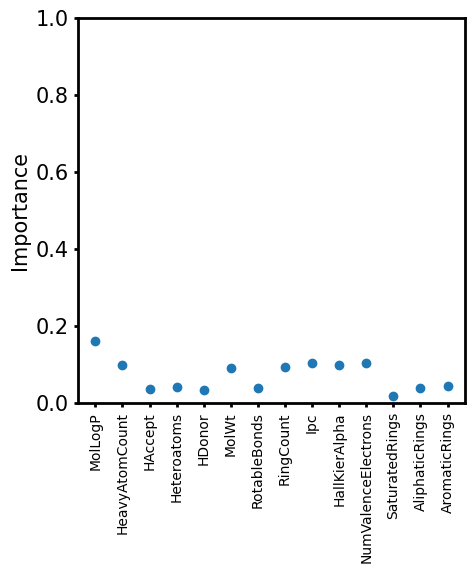

In [20]:
plt.plot(rf.feature_importances_, 'o')
plt.ylabel('Importance', fontsize=15)
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.ylim(0, 1)
plt.yticks(fontsize=15)
plt.tick_params(which='both',direction='out',length=3, width=2,)

# Hypertune parameters

In [21]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [22]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 110, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 11, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, None],
 'max_features': ['sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90, 100, 110]}


In [23]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 10, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      11, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 30, 40, 50, 60, 70,
                                                         80, 90, 100, 110]},
                   random_state=42, verbose=2)

In [24]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 11,
 'bootstrap': True}

In [40]:
rf_7 = RandomForestClassifier(n_estimators=100,
                              min_samples_split=5,
                              min_samples_leaf=1,
                              max_features="sqrt",
                              max_depth=5,
                              bootstrap=True)
# Fit the classifier
rf_7.fit(X_train, y_train)

# Make Predictions
predictions = rf_7.predict(X_test)
    
# Calculate metrics
accuracy = accuracy_score(predictions, y_test)
precision = precision_score(predictions, y_test)
recall = recall_score(predictions, y_test)

print("Accuracy on training set: %f" % rf_7.score(X_train, y_train))
print("Accuracy on test set: %f" % rf_7.score(X_test, y_test))
print("Precision: %f" % precision)
print("Recall: %f" % recall)

Accuracy on training set: 0.941368
Accuracy on test set: 0.870130
Precision: 0.795455
Recall: 0.972222


In [26]:
# Pull out one tree from the forest & export the image to a dot file:
export_graphviz(rf_7.estimators_[7], out_file = 'tree.dot', feature_names = X.columns, rounded = True, precision = 1)
# Use dot file to create a graph:
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file:
graph.write_png('tree.png')

In [27]:
rf_7.feature_importances_

array([0.18412405, 0.12125203, 0.03237818, 0.04636687, 0.02135114,
       0.09737322, 0.02321491, 0.07778303, 0.13352705, 0.06804229,
       0.09969124, 0.01421068, 0.04222288, 0.03846241])

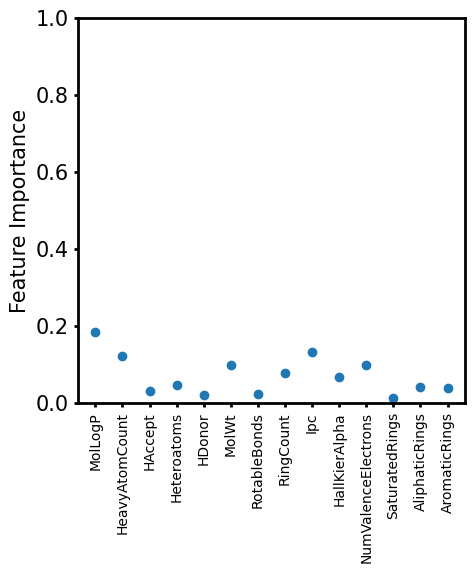

In [28]:
plt.plot(rf_7.feature_importances_, 'o', color='C0')
plt.ylabel('Feature Importance', fontsize=15)
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.ylim(0, 1)
plt.yticks(fontsize=15)
plt.tick_params(which='both',direction='out',length=3, width=2,)

Feature ranking:
1. feature 0 (0.184124)
2. feature 8 (0.133527)
3. feature 1 (0.121252)
4. feature 10 (0.099691)
5. feature 5 (0.097373)
6. feature 7 (0.077783)
7. feature 9 (0.068042)
8. feature 3 (0.046367)
9. feature 12 (0.042223)
10. feature 13 (0.038462)
11. feature 2 (0.032378)
12. feature 6 (0.023215)
13. feature 4 (0.021351)
14. feature 11 (0.014211)


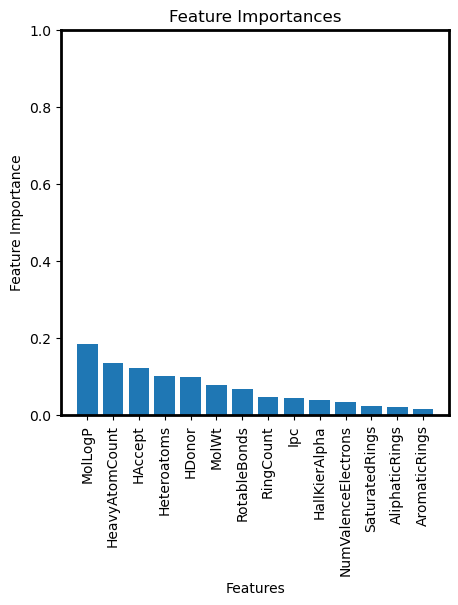

In [29]:
importances = rf_7.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="C0", align="center")
plt.xticks(range(X_train.shape[1]), X.columns,rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.ylim([0, 1.0])
plt.show()

# Analyzing ROC AUC

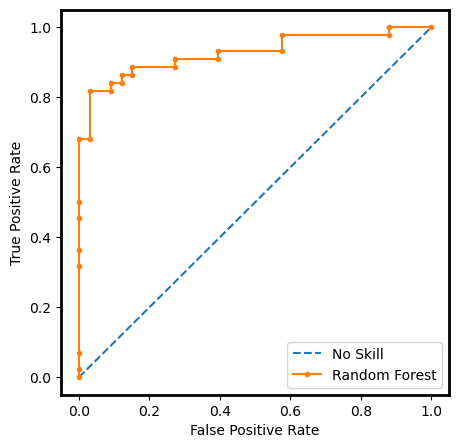

In [30]:
# predict probabilities
yhat = rf_7.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [31]:
# generate 2 class dataset
XX, yy = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(XX, yy, test_size=0.5, random_state=2)
# no skill model, stratified random class predictions
model = DummyClassifier(strategy='stratified')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
pos_probs = yhat[:, 1]
# calculate roc auc for No Skill
roc_auc = roc_auc_score(testy, pos_probs)
print('No Skill ROC AUC %.3f' % roc_auc)

# skilled model
yhat = rf_7.predict_proba(X_test)
pos_probs = yhat[:, 1]
# calculate roc auc
roc_auc = roc_auc_score(y_test, pos_probs)
print('Logistic ROC AUC %.3f' % roc_auc)

No Skill ROC AUC 0.547
Logistic ROC AUC 0.926
